# RAIL Evaluation - Check results against DC1 paper

Contact: _Julia Gschwend_ ([julia@linea.gov.br](mailto:julia@linea.gov.br)), _Sam Schmidt, Alex Malz, Eric Charles_

The purpose of this notebook is to validate the new implementation of the DC1 metrics, previously available on Github repository [PZDC1paper](https://github.com/LSSTDESC/PZDC1paper), now refactored to be part of RAIL Evaluation module. The metrics here were implemented in object-oriented Python 3, inheriting features from _qp_. In this notebook we use the same input dataset used in DC1 PZ paper ([Schmidt et al. 2020](https://arxiv.org/pdf/2001.03621.pdf)), copied from cori (/global/cfs/cdirs/lsst/groups/PZ/PhotoZDC1/photoz_results/TESTDC1FLEXZ).

In [1]:
from IPython.display import Markdown
from sample import Sample
from metrics import *
import os
%matplotlib inline
%reload_ext autoreload
%autoreload 2

<a class="anchor" id="sample"></a>

## Sample  



In [2]:
my_path = "/Users/julia/TESTDC1FLEXZ"

pdfs_file =  os.path.join(my_path, "Mar5Flexzgold_pz.out")
ztrue_file =  os.path.join(my_path, "Mar5Flexzgold_idszmag.out")

#pdfs_file =  os.path.join(my_path, "1pct_Mar5Flexzgold_pz.out")
#ztrue_file =  os.path.join(my_path, "1pct_Mar5Flexzgold_idszmag.out")

In [3]:
sample = Sample(pdfs_file, ztrue_file, code="FlexZBoost", name="DC1 paper data")
sample

Validation file from DC1 paper!


In [4]:
print(sample)

----------------------
Sample: DC1 paper data
Algorithm: FlexZBoost
----------------------
399356 PDFs with 200 probabilities each 
qp representation: interp 
z grid: 200 z values from 0.016282 to 1.99986 inclusive


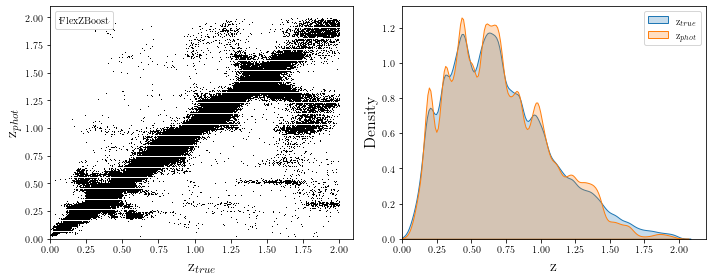

In [9]:
#sample.plot_old_valid()#gals=gals, colors=colors)
old_metrics_table = sample.plot_old_valid()

In [10]:
Markdown(old_metrics_table)

Metric | Value | DC1 paper  
 :---|---:|---: 
  scatter |      0.0155 | 0.0154  
bias |    -0.00027 | -0.00027 
outlier rate |       0.020 | 0.020 

<font color=red> Question for Sam/Alex: The point estimate statistics in table B1 refer to the total sample or after a magnitude cut? If the latter, what magnitude limit did you use? </font>

## Metrics

In [ ]:
%%time
metrics = Metrics(sample)

The metrics below are based on the PIT and the CDF(PIT), both computed via qp.Ensemble object method. The PIT array is computed as the qp.Ensemble CDF function for an object containing the photo-z PDFs, evaluated at the true $z$ for each galaxy. 

```python
        n = len(self._sample)
        self._pit = np.array([self._sample._pdfs[i].cdf(self._sample._ztrue[i])[0][0]
                              for i in range(n)])
        Qtheory = np.linspace(0., 1., self.n_quant)
        Qdata = np.quantile(self._pit, Qtheory)
        self._qq_vectors = (Qtheory, Qdata)
```



The PIT distribution is implemented as the normalized histogram of PIT values and the uniform U(0,1) is implemented as a mock normalized distribution with the same number of bins of PIT distribution, where all values are equal to $\frac{1.}{N_{quant}}$.     

```python         
        self._yscale_uniform = 1. / float(n_quant) # Uniform distribution amplitude
        self._xvals = Qtheory
        self._pit_dist, self._pit_bins_edges = np.histogram(self._pit, bins=n_quant, density=True) # Distribution of PIT values as it was a PDF
        self._uniform_dist = np.ones_like(self._pit_dist) * self._yscale_uniform
 ```       




Then a new qp.Ensemble object is instantiated for each distribution, PITs and U(0,1), to use the CDF functionallity (an ensemble with only 1 PDF each).

 ```python
        
        self._pit_ensamble = qp.Ensemble(qp.hist, data=dict(bins=self._pit_bins_edges,
                                                            pdfs=np.array([self._pit_dist])))
        self._uniform_ensamble = qp.Ensemble(qp.interp, data=dict(xvals=self._xvals,
                                                                  yvals=np.array([self._uniform_dist])))
        self._pit_cdf = self._pit_ensamble.cdf(self._xvals)[0]
        self._uniform_cdf = self._uniform_ensamble.cdf(self._xvals)[0]
```


Where $\mathrm{CDF} \small[ \hat{f}, z \small]$ represents `self._pit_cdf`  and $\mathrm{CDF} \small[ \tilde{f}, z \small]$ represents  `self._uniform_cdf` in the equations below. 

#### PIT-QQ plot

In [ ]:
metrics.plot_pit_qq() #savefig=True)

The DC1 results are stored in Metrics class object as a dictionary, inheriting from an independent class DC1 which exists only to provide the reference values.

In [ ]:
metrics.dc1['PIT out rate']['FlexZBoost']

If it is necessary to consult the names (keys) of metrics or codes available, the user can call the class DC1.

In [ ]:
dc1 = DC1()

In [ ]:
dc1.metrics

In [ ]:
dc1.codes

In [ ]:
dc1.table

### Results

Summary table with all metrics containing DC1 paper results for comparison (optional)

In [ ]:
metrics.markdown_table(show_dc1=True)

### Discussion

In the first attempt, the results do not match. The PIT outliers rate and CDE loss are close to the reference values. The KS, CvM, and AD tests still need to be fixed. Let's investigate these numbers by comparing the results with what we would get if using the scipy built-in statistical tests (implemented as alternative methods for each metric). 

### Kolmogorov-Smirnov  

$$
\mathrm{KS} \equiv \max_{PIT} \Big( \left| \ \mathrm{CDF} \small[ \hat{f}, z \small] - \mathrm{CDF} \small[ \tilde{f}, z \small] \  \right| \Big)
$$

```python
    def __init__(self, metrics, scipy=False):
        self._metrics = metrics
        if scipy:
            self._stat, self._pvalue = stats.kstest(metrics._pit, "uniform")
        else:
            self._stat, self._pvalue = np.max(np.abs(metrics._pit_cdf - metrics._uniform_cdf)), None # p=value TBD
        # update Metrics object
        metrics._ks_stat = self._stat
```


In [ ]:
ks = KS(metrics).stat
ks

In [ ]:
ks_sp = KS(metrics, scipy=True).stat
ks_sp

For the Komolgorof-Smirnov test, the values with and without scipy.stats.ks_test function are pretty close. The small diference may be explained by minor differences in the two methods, e.g. binning definition. 

### Cramer-von Mises


$$ \mathrm{CvM}^2 \equiv \int_{-\infty}^{\infty} \Big( \mathrm{CDF} \small[ \hat{f}, z \small] \ - \ \mathrm{CDF} \small[ \tilde{f}, z \small] \Big)^{2} \mathrm{dCDF}(\tilde{f}, z) $$ 

```python

    def __init__(self, metrics, scipy=False):
        if scipy:
            cvm_result = stats.cramervonmises(metrics._pit_dist, "uniform")
            self._stat, self._pvalue = cvm_result.statistic, cvm_result.pvalue
        else:
            self._stat, self._pvalue = np.sqrt(np.trapz((metrics._pit_cdf - metrics._uniform_cdf)**2, metrics._uniform_cdf)), None # p-value TBD
        # update Metrics object
        metrics._cvm_stat = self._stat
```

In [ ]:
cvm = CvM(metrics).stat
cvm

In [ ]:
cvm_sp = CvM(metrics, scipy=True).stat
cvm_sp

For the Cramer-von Mises test, when using the scipy.stats.cramervonmises method we get closer to the reference value, but not close enough yet. 

### Anderson-Darling 

$$ \mathrm{AD}^2 \equiv N_{tot} \int_{-\infty}^{\infty} \frac{\big( \mathrm{CDF} \small[ \hat{f}, z \small] \ - \ \mathrm{CDF} \small[ \tilde{f}, z \small] \big)^{2}}{\mathrm{CDF} \small[ \hat{f}, z \small] \big( 1 \ - \ \mathrm{CDF} \small[ \tilde{f}, z \small] \big)}\mathrm{dCDF}(\tilde{f}, z) $$ 

```python
    def __init__(self, metrics, ad_pit_min=0.0, ad_pit_max=1.0, scipy=False):

        mask_pit = (metrics._pit >= ad_pit_min) & (metrics._pit  <= ad_pit_max)
        if (ad_pit_min != 0.0) or (ad_pit_max != 1.0):
            n_out = len(metrics._pit) - len(metrics._pit[mask_pit])
            perc_out = (float(n_out)/float(len(metrics._pit)))*100.
            print(f"{n_out} outliers (PIT<{ad_pit_min} or PIT>{ad_pit_max}) removed from the calculation ({perc_out:.1f}%)")
        if scipy:
            #self._stat, self._critical_values, self._significance_levels = stats.anderson(metrics._pit[mask_pit])
            self._stat, self._critical_values, self._significance_levels = None, None, None
            print("Comparison to uniform distribution is not available in scipy.stats.anderson method.")
        else:
            ad_xvals = np.linspace(ad_pit_min, ad_pit_max, metrics._n_quant)
            ad_yscale_uniform = (ad_pit_max-ad_pit_min)/float(metrics._n_quant)
            ad_pit_dist, ad_pit_bins_edges = np.histogram(metrics._pit[mask_pit], bins=metrics._n_quant, density=True)
            ad_uniform_dist = np.ones_like(ad_pit_dist) * ad_yscale_uniform
            # Redo CDFs to consider outliers mask
            ad_pit_ensamble = qp.Ensemble(qp.hist, data=dict(bins=ad_pit_bins_edges, pdfs=np.array([ad_pit_dist])))
            ad_pit_cdf = ad_pit_ensamble.cdf(ad_xvals)[0]
            ad_uniform_ensamble = qp.Ensemble(qp.hist,
                                              data=dict(bins=ad_pit_bins_edges, pdfs=np.array([ad_uniform_dist])))
            ad_uniform_cdf = ad_uniform_ensamble.cdf(ad_xvals)[0]
            numerator = ((ad_pit_cdf - ad_uniform_cdf)**2)
            denominator = (ad_uniform_cdf*(1.-ad_uniform_cdf))
            with np.errstate(divide='ignore', invalid='ignore'):
                self._stat = np.sqrt(float(len(metrics._sample)) * np.trapz(np.nan_to_num(numerator/denominator), ad_uniform_cdf))
            self._critical_values = None
            self._significance_levels = None
```

For the Anderson-Darling test, the comparison to a uniform distribution is not available in scipy.stats.anderson method, so using it does not make sense. 

Let's remove the catastrophic autliers (as done in the paper), to see the impact.

In [ ]:
ad = AD(metrics, ad_pit_min=0.01, ad_pit_max=0.99).stat
ad

Result: it does not help. 


https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html


https://stackoverflow.com/questions/53909526/interpreting-the-anderson-darling-test-scipy 




## Conclusion

<font color=red> TBD </font>